In [9]:
import sys
import os
sys.path.append('..')

In [10]:
import random
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Solutions
from library.solution import Solution
from library.custom.custom_solutions import WSOSolution, WSOGASolution
from library.data.relationship_matrix import relationship_matrix

# Operators
from library.algorithms.genetic_algorithms.algorithm import genetic_algorithm
from library.algorithms.genetic_algorithms.selection import fitness_proportionate_selection
from library.custom.custom_crossover import cycle_crossover, partially_matched_crossover, pos_based_crossover
from library.custom.custom_mutation import block_swap_mutation, n_swap_mutation, displacement_mutation, shuffle_subsequence_mutation
from library.custom.custom_selection import tournament_selection, ranking_selection

# Statistical Analysis
# from scipy.stats import f_oneway

## Utility functions

In [11]:
def plot_fitness_over_gen(fitness_dfs: dict[str, pd.DataFrame]):
    """
    
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    handles, labels = [], []

    for config_name, df in fitness_dfs.items():
        mean_fitness = df.mean(axis=0)
        median_fitness = df.median(axis=0)
        
        line1, = axes[0].plot(mean_fitness.index, mean_fitness.values, label=config_name)
        axes[1].plot(median_fitness.index, median_fitness.values, label=config_name)

        handles.append(line1)
        labels.append(config_name)

    axes[0].set_title("Mean Fitness Across Generations")
    axes[1].set_title("Median Fitness Across Generations")

    for ax in axes:
        ax.set_xlabel("Generation")
        ax.set_ylabel("Fitness")
        ax.grid(True)

    # Shared boxed legend below
    legend = fig.legend(
        handles,
        labels,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.15),
        ncol=2,
        frameon=True,
        borderpad=1
    )

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.25)
    plt.show()

## Global parameters

In [ ]:
POP_SIZE = 50
GENERATIONS = 150 # Increased because Phase 1 didn't seem to be converging yet
NBR_RUNS = 30

## Phase 2 Experiment: Hyperparameters
Combination chosen for phase 2: partially_matched_crossover0.8_n_swap_mutation0.2_ranking_selection

In [ ]:
grid_params = {
    "xo_prob": [random.uniform(0, 1/5), random.uniform(1/5, 2/5), random.uniform(2/5, 3/5), random.uniform(3/5, 4/5), random.uniform(4/5, 1)],
    "mut_prob": [random.uniform(0, 1/5), random.uniform(1/5, 2/5), random.uniform(2/5, 3/5), random.uniform(3/5, 4/5), random.uniform(4/5, 1)],
    "n_swap": [3, 6]
}

finetune_fitness_results = {}

for xo_prob in grid_params["xo_prob"]:
    for mut_prob in grid_params["mut_prob"]:
        for n_swap in grid_params["n_swap"]:
            # Create empty dataframe for each configuration
            # Columns have the fitness in each generation, rows will have results for each run
            df = pd.DataFrame(columns=range(GENERATIONS)) # Shape will be runs x gen

            for run_nr in range(NBR_RUNS):
                _, fitness_over_gens = genetic_algorithm(
                    initial_population=[
                        WSOGASolution(
                        relationship_matrix=relationship_matrix,
                        # UPDATE mutation function to best config
                        mutation_function=lambda repr, mut_prob: n_swap_mutation(repr, mut_prob=mut_prob, n=n_swap), # lambda function to pass the n_swap parameter
                        crossover_function=partially_matched_crossover, # UPDATE crossover function to best config
                        ) for _ in range(POP_SIZE)
                    ],
                    max_gen=GENERATIONS,
                    selection_algorithm=ranking_selection, #UPDATE selection algo to best config
                    maximization=True,
                    xo_prob=xo_prob,
                    mut_prob=mut_prob,
                    elitism=True
                )
                df.loc[run_nr] = fitness_over_gens

            # Create a label for the config
            config_label = f"xo_prob={round(xo_prob, 2)}_mut_prob={round(mut_prob, 2)}_n_swap={n_swap}_elitism={elitism}"
        
            # Save configuration results in the dictionary
            finetune_fitness_results[config_label] = df

            # creating an output directory to save experiment results
            output_dir = "fitness_results/phase2"
            os.makedirs(output_dir, exist_ok=True)

            # saving each configuration result as a CSV
            df.to_csv(os.path.join(output_dir, f"{config_label}.csv"), index=False)

Top 8 configurations sorted desc:
xo_prob=0.3_mut_prob=0.22_n_swap=3_elitism=True: 65400.0
xo_prob=0.19_mut_prob=0.22_n_swap=3_elitism=True: 63500.0
xo_prob=0.3_mut_prob=0.52_n_swap=3_elitism=True: 59200.0
xo_prob=0.74_mut_prob=0.22_n_swap=3_elitism=True: 59000.0
xo_prob=0.74_mut_prob=0.04_n_swap=3_elitism=True: 58500.0
xo_prob=0.19_mut_prob=0.52_n_swap=3_elitism=True: 57600.0
xo_prob=0.3_mut_prob=0.04_n_swap=3_elitism=False: 57300.0
xo_prob=0.42_mut_prob=0.22_n_swap=6_elitism=True: 57000.0


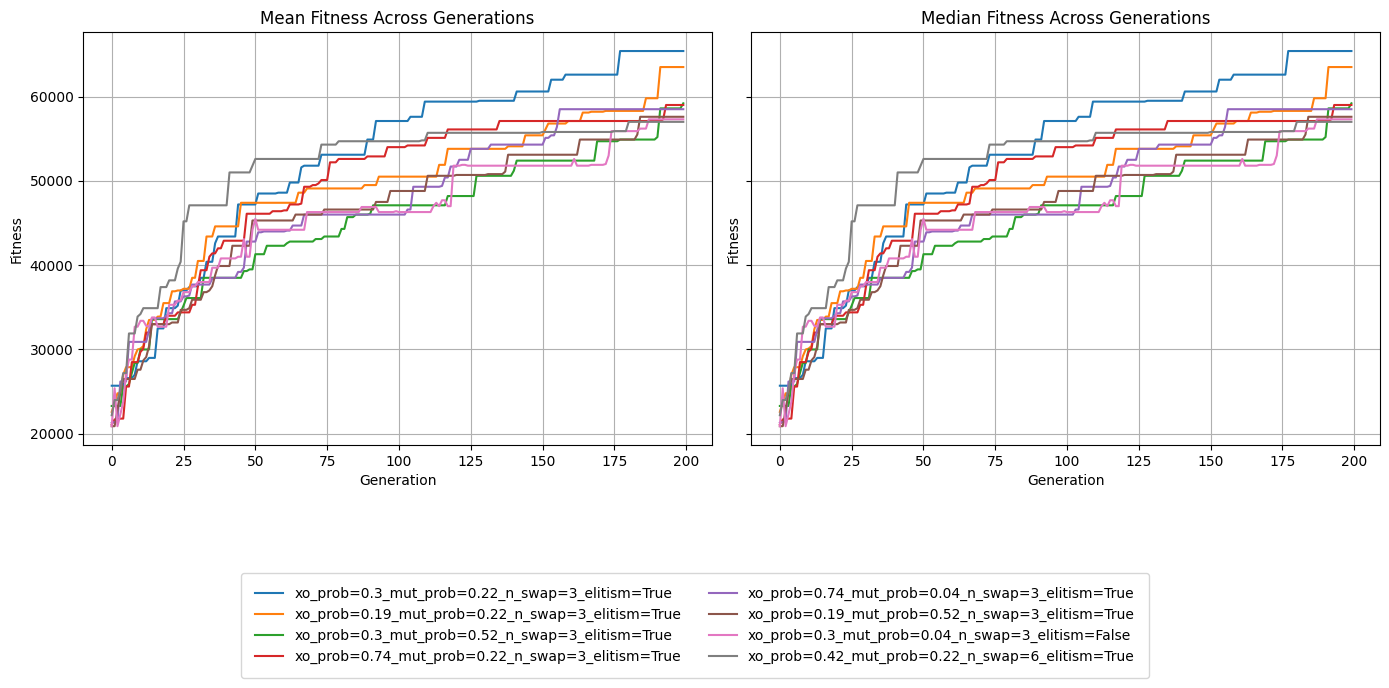

In [15]:
# Select the top 8 configurations with the highest mean fitness in the last generation
last_gen_fitness = {
    config: df[GENERATIONS - 1].mean() for config, df in finetune_fitness_results.items()
}

# Sort descending and take the top 8
top_configs = sorted(last_gen_fitness, key=last_gen_fitness.get, reverse=True)[:8]

print("Top 8 configurations sorted desc:")
for config in top_configs:
    print(f"{config}: {last_gen_fitness[config]}")

# Dictionary for plotting
top_fitness_dfs = {config: finetune_fitness_results[config] for config in top_configs}
plot_fitness_over_gen(top_fitness_dfs)